# Jointed CNN (images) and DNN (tabular data)

In [1]:
%matplotlib inline
import os
import random
import math
import numpy as np
import pandas as pd
from collections import Counter
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from keras.models import Model
from keras.layers import Input, Embedding, concatenate, Flatten
from keras.layers.core import Dense, Reshape, Lambda
from keras.applications.vgg19 import VGG19
#from keras.applications import MobileNet
from keras.utils import to_categorical
from keras.preprocessing.image import load_img, save_img, img_to_array
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.initializers import Constant
from tensorflow import set_random_seed
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Joint_DataGenerator import DataGenerator
import pickle
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


## Paths and file names

In [2]:
BASE_DIR = "../.."
DATA_DIR = "data"
IMG_DIR = "images"
IMG_EMBEDDED_DIR = "src/VGG19_FC2_embed"
DATA_FILE = "balanced_data.csv"
WORD_EMBEDDING_DIM = 100
GLOVE_DIR = "glove.6B"
GLOVE_FILE = "glove.6B." +  str(WORD_EMBEDDING_DIM) + 'd.txt'
GLOVE_VOCSIZE = 400000
INS_USERNAME_EMBEDDING_DIM = 20
MAX_WORDS_IN_CAPTION = 40
SPLIT_RATIO = [0.7, 0.15, 0.15] # training : validation : test

data_path = os.path.join(BASE_DIR, DATA_DIR, DATA_FILE)
img_path = os.path.join(BASE_DIR, IMG_DIR)
imgEmbd_dir = os.path.join(BASE_DIR, IMG_EMBEDDED_DIR)

## tabular data

In [3]:
# read in data file
data = pd.read_csv(data_path)
# image data is too big to fit in memory
# build a imgID-img_shortCode dictionary for data generator
data.reset_index(drop=False, inplace=True)
imgID_shortCode = {idx : code for idx, code in zip(data.index, data.media_shortcode)}

# Dimensoins tabular data
N_ins_username = data.poster_instagram_username.nunique()
N_poster_account_type = data.poster_account_type.nunique()
N_media_type =data.media_type.nunique()
N_caption_type = data.caption_type.nunique()

# dimension of raw input data, 1: ins_username and image ID
raw_input_dim = MAX_WORDS_IN_CAPTION + N_poster_account_type + \
                N_media_type + N_caption_type + 1 + 1

# Transform the tabular data to usable numerial data to feed in the network
## Transform caption and username data -- for embedding

In [4]:
# build word : vec dictionary from GloVe
glove_path = os.path.join(BASE_DIR, GLOVE_DIR,  GLOVE_FILE)
glove_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype = 'float', sep=' ')
        glove_index[word] = coefs

# prepare tokenizer
captions = data.media_caption.astype(str)
token = Tokenizer()
token.fit_on_texts(captions)
vocab_size = len(token.word_index) + 1 # word_index is 1-indexed, puls 1-dim for OOV and padded words
print("The size of the vocabulary is: ", vocab_size)

# integer encode the documents
encoded_captions = token.texts_to_sequences(captions)
# pad captions that are less than MAX_WORDS_IN_CAPTION words
padded_captions = pad_sequences(encoded_captions, maxlen=MAX_WORDS_IN_CAPTION, padding='post')

The size of the vocabulary is:  23376


In [5]:
# use "represented_data" matrix, to store the encoded data
represented_data = padded_captions.copy()

# create a weight matrix for all words in captions
embedding_matrix = np.zeros((vocab_size, WORD_EMBEDDING_DIM))
for word, idx in token.word_index.items(): # word_index is 1-indexed, zero vector for padding
    embedding_vector = glove_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [6]:
# poster_instagram_username N_ins_username dim categorial, needs to be embedded to INS_USERNAME_EMBEDDING_DIM dim
def OrdinalEncoder(categories):
    """ An ordinal Encoder for data pre-processing,
        Not strictly ordinal, but does the work.
    
        Args:
            categories: numpy arrary or list of categories              
        Returns:
            numpy array of ordinal encoded entries        
    """
    counter = Counter(categories).most_common() # indices assigned based on number of occurances
    unique_ctgrs = [x[0] for x in counter] # list of categories, guaranteed in fixed order due to sorting
    encoder = {ctgr : idx for idx, ctgr in enumerate(unique_ctgrs)}
        
    res = [0] * len(categories)
    res = [encoder[ctgr] for ctgr in categories]
    return np.array(res, dtype='int')

In [7]:
ins_usernames = data.poster_instagram_username
encoded_ins_usernames = OrdinalEncoder(ins_usernames)
encoded_ins_usernames = np.array(encoded_ins_usernames).reshape(-1, 1)
# concatenate encoded_ins_usernames to represented_data
represented_data = np.concatenate((represented_data, encoded_ins_usernames), axis = 1)

In [8]:
print(len(represented_data))
print(len(represented_data[0]))

101914
41


## Transform poster_account_type, media_type and caption_type -- one-hot

In [9]:
for ctgr in ['poster_account_type', 'media_type', 'caption_type']:
    col=data[ctgr]
    one_hot_encoded = to_categorical(OrdinalEncoder(col))
    represented_data = np.concatenate((represented_data, one_hot_encoded), axis = 1)

## Last piece of raw input: numerical ID of images, use it to locate img short code

In [10]:
imgID_arr=np.array(data.index).reshape(-1,1)
represented_data = np.concatenate((represented_data, imgID_arr), axis = 1)

In [11]:
print(represented_data.shape)
print(len(represented_data[0]))
if len(represented_data[0]) != raw_input_dim:
    print("Input dimension is wrong!")

(101914, 59)
59


# Split all data into training, validation and test sets
## Multi-hot encoding for multi-labels

In [12]:
def multi_hot_encoding(labels):
    """ multi-hot encoding for the labels of each meida post 
        Args:
            labels: list, dimension of rows may not be same
        Return:
            num_of_classes: int, total number of classes
            res: array, num_of_examples x num_of_classes, multi-hot encoded array
    """
    # number of classes
    num_examples, min_idx, max_idx = len(labels), float('inf'), -float('inf')
    for row in labels:
        for col in row:
            if col < min_idx:
                min_idx = col
            if col > max_idx:
                max_idx = col
    num_of_classes = max_idx - min_idx + 1
    
    res = np.zeros((num_examples, max_idx-min_idx+1), dtype = int)
    for row in range(len(labels)):
        lbls = labels[row]
        for col in lbls:
            res[row, col] = 1
    return num_of_classes, res

In [13]:
labels_str = data.label.values
labels = []
for str_label in labels_str:
    label = [int(i) for i in str_label[1:-1].split(',')]
    labels.append(label)

num_of_classes, encoded_labels_arr = multi_hot_encoding(labels)
represented_data = np.concatenate((represented_data, encoded_labels_arr), axis = 1)

In [14]:
def split_data(orig_data, split_ratio, num_of_classes):
    """ Split dataframe into train, validation and test datasets."""
    
    np.random.seed(42)
    np.random.shuffle(orig_data)
    data_after_split, tmp, length = {}, {}, len(orig_data)
    
    tmp['train'], tmp['val'], tmp['test'] = np.split(
        orig_data, [int(split_ratio[0] * length), int(1 - split_ratio[2] * length)], axis=0)
    
    for sett in ['train', 'val', 'test']:
        X = tmp[sett][:, :-num_of_classes]
        Y = tmp[sett][:, -num_of_classes:]
        data_after_split['X' + '_' + sett] = X
        data_after_split['Y' + '_' + sett] = Y

    print(data_after_split['X_train'].shape, data_after_split['Y_train'].shape,
          data_after_split['X_val'].shape, data_after_split['Y_val'].shape,
          data_after_split['X_test'].shape, data_after_split['Y_test'].shape)
    return data_after_split

In [15]:
print(represented_data.shape)
data_after_split = split_data(represented_data, SPLIT_RATIO, num_of_classes)

(101914, 99)
(71339, 59) (71339, 40) (15289, 59) (15289, 40) (15286, 59) (15286, 40)


## Build and train the joint model

In [16]:
# To ensure reproducible results
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Specify inputs, categorial one-hot and images are 4096-dim vectors
media_caption_in = Input(shape=(MAX_WORDS_IN_CAPTION,))
poster_instagram_username_in = Input(shape=(1,))
other_categorical_in = Input(shape=(N_poster_account_type + N_media_type + N_caption_type, ))
image_in = Input(shape=(4096,))

#regularization coefficient
regularizer_param = 0.0001

# Two Embedding layers
caption_embedding = Embedding(input_dim=vocab_size, output_dim=WORD_EMBEDDING_DIM, 
                              embeddings_initializer=Constant(embedding_matrix), 
                              input_length=MAX_WORDS_IN_CAPTION, trainable=True, 
                              name = 'word_emb')(media_caption_in)

ins_username_embedding = Embedding(N_ins_username, INS_USERNAME_EMBEDDING_DIM, 
                                   name = 'insID_emb')(poster_instagram_username_in)

# Average and reshape the caption and ins_username embedding
# Total dim of tabular data is 100 + 20 + 5+ 6 + 6 = 137
avg_caption_embedding = Lambda(lambda x: K.mean(x, axis = 1, keepdims=False))(caption_embedding)
reshape_caption_embedding = Reshape(target_shape=(WORD_EMBEDDING_DIM,))
reshape_ins_username = Reshape(target_shape=(INS_USERNAME_EMBEDDING_DIM,))

# FC layers for image data, output a 256-dim vector
image=Dense(1024, activation='relu',
       kernel_regularizer=regularizers.l2(regularizer_param))(image_in)
image=Dense(512, activation='relu',
       kernel_regularizer=regularizers.l2(regularizer_param))(image)
image=Dense(256, activation='relu',
       kernel_regularizer=regularizers.l2(regularizer_param))(image)

# Combine the tabular and image input, dim = 137+256 = 393
combined = concatenate([reshape_caption_embedding(avg_caption_embedding), 
                  reshape_ins_username(ins_username_embedding), other_categorical_in, image])
    
# Another two FC layers after concatenation
hidden_1 = Dense(128, activation='relu', 
                 kernel_regularizer=regularizers.l2(regularizer_param))(combined)
hidden_2 = Dense(64, activation='relu', 
                 kernel_regularizer=regularizers.l2(regularizer_param))(hidden_1)
output = Dense(num_of_classes, activation='sigmoid',
               kernel_regularizer=regularizers.l2(regularizer_param))(hidden_2)

# Compile with categorical crossentropy and adam
model = Model(inputs=[media_caption_in, poster_instagram_username_in, other_categorical_in, image_in], 
              outputs = [output])

def precision(y_true, y_pred):
    #Precision metric.
    y_pred = K.cast(K.greater(y_pred,0.5),dtype=float)
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(y_pred))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    #Recall metric.
    y_pred = K.cast(K.greater(y_pred,0.5),dtype=float)
    true_positives = K.sum(K.round(y_true * y_pred))
    actural_positives = K.sum(K.round(y_true))
    recall = true_positives / (actural_positives + K.epsilon())
    return recall

def exact_match_ratio(y_true, y_pred):
    #pred = tf.equal(tf.round(y_logits), tf.round(y_true))
    predictions = tf.to_float(tf.greater_equal(y_pred, 0.5))
    pred_match = tf.equal(predictions, tf.round(y_true))
    exact_match = tf.reduce_min(tf.to_float(pred_match), axis=1)
    return tf.reduce_mean(exact_match)  

model.compile(loss='binary_crossentropy', 
            optimizer='adam', metrics=[precision, recall, exact_match_ratio])

print(model.summary())

# Compile model
batch_size = 128

training_generator = DataGenerator(data_after_split['X_train'], data_after_split['Y_train'],
                                      imgID_shortCode, imgEmbd_dir, batch_size, MAX_WORDS_IN_CAPTION)

validation_generator = DataGenerator(data_after_split['X_val'], data_after_split['Y_val'],
                                      imgID_shortCode, imgEmbd_dir, batch_size, MAX_WORDS_IN_CAPTION)
    
# validation_steps: Total number of steps (batches of samples) to yield from validation_data generator 
# before stopping at the end of every epoch. It should typically be equal to the number of samples of 
# your validation dataset divided by the batch size.
history = model.fit_generator(generator=training_generator, validation_data = validation_generator,
                    steps_per_epoch = int(math.ceil(len(data_after_split['X_train']) / batch_size)),
                    validation_steps = int(math.ceil(len(data_after_split['X_val']) / batch_size)),
                    shuffle=True, epochs=25)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
word_emb (Embedding)            (None, 40, 100)      2337600     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                  

In [17]:
with open('Joint_history', 'wb') as fin:
        pickle.dump(history.history, fin)
model.save('Joint_model.h5')

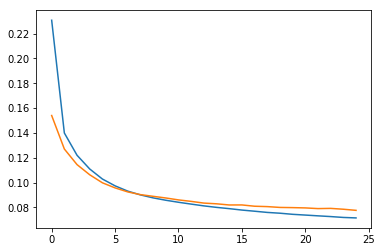

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [19]:
def get_precision(y_true, y_pred):
    #Precision metric.
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <0.5] = 0
    true_positives = np.sum(y_pred*y_true)
    predicted_positives = np.sum(y_pred)
    return true_positives / predicted_positives

def get_recall(y_true, y_pred):
    #Recall metric.
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <0.5] = 0
    true_positives = np.sum(y_pred*y_true)
    actural_positives = np.sum(y_true)
    return true_positives / actural_positives

def get_exact_match_ratio(y_true, y_pred):
    match = np.equal(y_pred, y_true)
    match = np.amin(match, axis=1)
    exact_match_ratio = np.mean(match)
    return exact_match_ratio

In [20]:
# test set data generator, note tht batch size = number of samples
test_generator = DataGenerator(data_after_split['X_test'], data_after_split['Y_test'],
                                      imgID_shortCode, imgEmbd_dir, batch_size=len(data_after_split['X_test']))

y_pred = model.predict_generator(generator=test_generator)
y_true = data_after_split['Y_test']

precision, recall,  = get_precision(y_true, y_pred), get_recall(y_true, y_pred)
exact_math_ratio = get_exact_match_ratio(y_true, y_pred)

print("precision, recall and exact match ratio for test set are %.4f, %.4f and %.4f" \
      %(precision, recall, exact_math_ratio))

precision, recall and exact match ratio for test set are 0.8324, 0.5634 and 0.5408


In [21]:
classID_className = {0: 'color cosmetics:eye:eyebrow', 1: 'skincare:skincare:moisturizer', 2: 'color cosmetics:eye:eyeshadow', 3: 'color cosmetics:eye:mascara', 4: 'accessories:accessories:brush', 5: 'fragrance:fragrance:fragrance', 6: 'skincare:skincare:cleanser', 7: 'accessories:accessories:tool', 8: 'nail:nail:nail polish', 9: 'color cosmetics:eye:eye palette', 10: 'bath body:bath body:wash', 11: 'hair:style:styling products', 12: 'skincare:skincare:treatments', 13: 'color cosmetics:face:powder', 14: 'skincare:skincare:mask', 15: 'bath body:bath body:body lotion', 16: 'hair:cleanse:conditioner', 17: 'color cosmetics:cheek:cheek palette', 18: 'color cosmetics:lip:lipstick', 19: 'hair:treat:hair treatments', 20: 'color cosmetics:cheek:highlighter', 21: 'hair:cleanse:shampoo', 22: 'color cosmetics:face:setting spray', 23: 'color cosmetics:cheek:blush', 24: 'skincare:skincare:face suncare', 25: 'color cosmetics:eye:eyeliner', 26: 'color cosmetics:face:face palette', 27: 'color cosmetics:face:foundation', 28: 'color cosmetics:lip:lip balm', 29: 'skincare:skincare:face mist', 30: 'skincare:skincare:eyecare', 31: 'color cosmetics:eye:lash', 32: 'color cosmetics:lip:lip gloss', 33: 'color cosmetics:face:face primer', 34: 'color cosmetics:face:concealer', 35: 'color cosmetics:cheek:bronzer', 36: 'skincare:skincare:toner', 37: 'color cosmetics:lip:lip liner', 38: 'bath body:bath body:body suncare', 39: 'bath body:bath body:body glitter'}

In [22]:
target_names = [i.split(':')[2] for i in classID_className.values()]
report= classification_report(y_true, y_pred, target_names = target_names)
print(report)

                  precision    recall  f1-score   support

         eyebrow       0.67      0.33      0.45       326
     moisturizer       0.42      0.10      0.16       405
       eyeshadow       0.64      0.05      0.10       311
         mascara       0.90      0.52      0.66       613
           brush       0.93      0.57      0.70       498
       fragrance       0.94      0.71      0.81       480
        cleanser       0.82      0.46      0.59       662
            tool       0.91      0.78      0.84       953
     nail polish       0.99      0.90      0.94       506
     eye palette       0.73      0.54      0.62       880
            wash       0.85      0.73      0.79       534
styling products       0.85      0.71      0.78       771
      treatments       0.73      0.59      0.65       844
          powder       0.78      0.27      0.40       438
            mask       0.73      0.20      0.31       292
     body lotion       0.73      0.64      0.68       565
     conditio

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# What did we get wrong?

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1080x576 with 0 Axes>

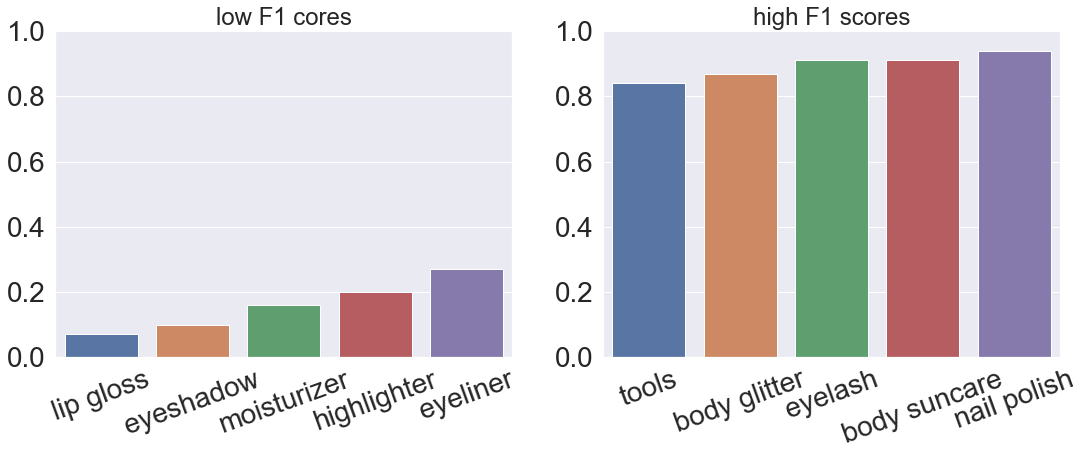

In [24]:
# precision, reall, exact match ratio
Low_f1 = [0.07, 0.10, 0.16, 0.20, 0.27]
High_f1 = [0.84, 0.87, 0.91, 0.91, 0.94]

# Draw barplots
LowF1_products = ["lip gloss", "eyeshadow", "moisturizer", "highlighter", "eyeliner"]
HighF1_products = ["tools", "body glitter", "eyelash", "body suncare", "nail polish"]
sns.set(font_scale = 1.8)
plt.figure(figsize=(15,8))
fig, axes = plt.subplots(1, 2, figsize=(18, 6), facecolor='w', edgecolor='k')

sns.set(font_scale = 1.8)
for axe, f1, products, title in zip(axes.flat, [Low_f1, High_f1], 
                            [LowF1_products, HighF1_products], ['low F1 cores', 'high F1 scores']):
    sns.barplot(products, f1, ax=axe)
    #axe = sns.barplot(metrics, data)
    for item in axe.get_xticklabels():
        item.set_rotation(20)
    axe.set_title(title, fontsize=24)
    #axe.set_xlabel('metric', size=26)
    axe.tick_params(axis='both', labelsize=28)
    axe.set_ylim([0, 1])
    
    ##add the text labels for each bar
    #rects = axe.patches
    #labels = [str("%.2f" %i) for i in f1]
    #for rect, label in zip(rects, labels):
    #    height = rect.get_height()
    #    axe.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize=22)